### Read-in downloaded data

In [1]:
import os
import logging
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

In [2]:
def get_broadcaster_data_set(train_ds):
    broadcasters = train_ds.cache().map(lambda x: x["broadcaster"], num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    broadcasters_ds = tf.data.Dataset.from_tensor_slices(
        np.unique(list(broadcasters.as_numpy_iterator())))
    return broadcasters_ds


def get_list(training_data, key):
    return training_data.batch(1_000_000).map(lambda x: x[key], num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)


def get_unique_list(data):
    return np.unique(np.concatenate(list(data)))


def load_data_file_cold(file, stats):
    print('loading file:' + file)
    training_df = pd.read_csv(
        file,
        skiprows=[0],
        names=["viewer",
               "broadcaster",
               "viewer_age",
               "viewer_gender",
               "viewer_longitude",
               "viewer_latitude",
               "viewer_lang",
               "viewer_country",
               "broadcaster_age",
               "broadcaster_gender",
               "broadcaster_longitude",
               "broadcaster_latitude",
               "broadcaster_lang",
               "broadcaster_country",
               "duration", 
               "viewer_network", 
               "broadcaster_network", 
               "viewer_lat_long_cluster",
               "rank"], 
        dtype={
            'viewer': np.unicode,
            'broadcaster': np.unicode,
            'viewer_age': np.single,
            'viewer_gender': np.unicode,
            'viewer_longitude': np.single,
            'viewer_latitude': np.single,
            'viewer_lang': np.unicode,
            'viewer_country': np.unicode,
            'broadcaster_age': np.single,
            'broadcaster_longitude': np.single,
            'broadcaster_latitude': np.single,
            'broadcaster_lang': np.unicode,
            'broadcaster_country': np.unicode,
            'viewer_network': np.unicode,
            'broadcaster_network': np.unicode,
            'viewer_lat_long_cluster': np.unicode,
            'rank': np.int
        })

    values = {
        'viewer': 'unknown',
        'broadcaster': 'unknown',
        'viewer_age': 30,
        'viewer_gender': 'unknown',
        'viewer_longitude': 0,
        'viewer_latitude': 0,
        'viewer_lang': 'unknown',
        'viewer_country': 'unknown',
        'broadcaster_age': 30,
        'broadcaster_longitude': 0,
        'broadcaster_latitude': 0,
        'broadcaster_lang': 'unknown',
        'broadcaster_country': 'unknown',
        'duration': 0,
        'viewer_network': 'unknown',
        'broadcaster_network': 'unknown',
        'viewer_lat_long_cluster': '0',
        'rank': 1
    }
    training_df.fillna(value=values, inplace=True)
    print(training_df.head(10))
    print(training_df.iloc[-10:])
    # stats.send_stats('data-size', len(training_df.index))
    samples = training_df.sample(frac=.1)
    return samples


def load_training_data_cold(file, stats):
    ratings_df = load_data_file_cold(file, stats)
    print('creating data set')
    training_ds = (
        tf.data.Dataset.from_tensor_slices(
            ({
                "viewer": tf.cast(
                    ratings_df['viewer'].values,
                    tf.string),
                "viewer_gender": tf.cast(
                    ratings_df['viewer_gender'].values,
                    tf.string),
                "viewer_lang": tf.cast(
                    ratings_df['viewer_lang'].values,
                    tf.string),
                "viewer_country": tf.cast(
                    ratings_df['viewer_country'].values,
                    tf.string),
                "viewer_age": tf.cast(
                    ratings_df['viewer_age'].values,
                    tf.int32),
                "viewer_longitude": tf.cast(
                    ratings_df['viewer_longitude'].values,
                    tf.float16),
                "viewer_latitude": tf.cast(
                    ratings_df['viewer_latitude'].values,
                    tf.float16),
                "broadcaster": tf.cast(
                    ratings_df['broadcaster'].values,
                    tf.string),
                "viewer_network": tf.cast(
                    ratings_df['viewer_network'].values,
                    tf.string),
                "broadcaster_network": tf.cast(
                    ratings_df['broadcaster_network'].values,
                    tf.string),
                "viewer_lat_long_cluster": tf.cast(
                    ratings_df['viewer_lat_long_cluster'].values,
                    tf.string),
            })))

    return training_ds


def prepare_training_data_cold(train_ds):
    print('prepare_training_data')
    training_ds = train_ds.cache().map(lambda x: {
        "broadcaster": x["broadcaster"],
        "viewer": x["viewer"],
        "viewer_gender": x["viewer_gender"],
        "viewer_lang": x["viewer_lang"],
        "viewer_country": x["viewer_country"],
        "viewer_age": x["viewer_age"],
        "viewer_longitude": x["viewer_longitude"],
        "viewer_latitude": x["viewer_latitude"],
        "viewer_network": x["viewer_network"],
        "broadcaster_network": x["broadcaster_network"],
        "viewer_lat_long_cluster": x["viewer_lat_long_cluster"],
    }, num_parallel_calls=tf.data.AUTOTUNE,
       deterministic=False)

    print('done prepare_training_data')
    return training_ds


def current_milli_time():
    return round(time.time() * 1000)

### Read-in data

In [3]:
print("training_process")
start_time = current_milli_time()
broadcaster_embedding_dimension = 32
viewer_embedding_dimension = 32

batch_size = 1638
learning_rate = 0.05
epochs = 10
top_k = 199

training_process


In [4]:
!ls csv

0e9cd673-8e06-4810-b370-8b9930ee312a.csv
2021-09-22.csv
2021-09-23.csv
2021-10-01.csv
2021-10-05.csv
2021-10-07.csv
50c39121-3de2-4b6b-b134-bb51732c1d6f.csv
a3d86f3b-eb45-4641-b05d-30dff7423e6b.csv
viewer_lat_long_centroids.csv


In [5]:
training_dataset = load_training_data_cold("csv/2021-10-05.csv", "")
train = prepare_training_data_cold(training_dataset)
broadcasters_data_set = get_broadcaster_data_set(training_dataset)

loading file:csv/2021-10-05.csv
                                            viewer  \
0  37 5e 49 40 70 ff b1 a1 51 e1 f0 d6 77 15 d2 32   
1  dd 83 c6 59 b2 3c e3 3c a1 49 47 1c ef 5f 1d 53   
2  d5 e3 54 3c be 21 ee 42 c5 db 19 60 3e 9e b7 72   
3  dd 83 c6 59 b2 3c e3 3c a1 49 47 1c ef 5f 1d 53   
4  08 c7 b8 62 05 d4 b9 80 5b 96 a2 93 0e 48 88 6b   
5  dd 83 c6 59 b2 3c e3 3c a1 49 47 1c ef 5f 1d 53   
6  37 5e 49 40 70 ff b1 a1 51 e1 f0 d6 77 15 d2 32   
7  dd 83 c6 59 b2 3c e3 3c a1 49 47 1c ef 5f 1d 53   
8  37 5e 49 40 70 ff b1 a1 51 e1 f0 d6 77 15 d2 32   
9  dd 83 c6 59 b2 3c e3 3c a1 49 47 1c ef 5f 1d 53   

                                       broadcaster  viewer_age viewer_gender  \
0  34 9a c3 50 0e cf a4 a8 b7 d0 a4 a1 b9 d1 bd f2        43.0        female   
1  b6 cb 91 77 b1 7f 4e 70 be 4d bb 5e 88 3f c2 dd        50.0          male   
2  7f 8c 21 c9 e4 6f a2 fe 01 fa 97 4f 5b 2a 82 3d        22.0        female   
3  73 83 97 f7 28 69 1c 25 4a ca d4 f6 24 9a a6 32   

creating data set


2021-10-12 10:07:01.560177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


prepare_training_data
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
done prepare_training_data
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team.

2021-10-12 10:07:02.093192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
print("get lists")

user_genders = get_list(train, "viewer_gender")
user_langs = get_list(train, "viewer_lang")
user_countries = get_list(train, "viewer_country")
user_networks = get_list(train, "viewer_network")

viewer_age = get_list(train, "viewer_age")
viewer_longitude = get_list(train, "viewer_longitude")
viewer_latitude = get_list(train, "viewer_latitude")

broadcaster_ids = get_list(train, "broadcaster")

data_set_size = len(broadcaster_ids)

get lists
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity

In [7]:
print("get_unique_list")
unique_broadcasters = get_unique_list(broadcaster_ids)
unique_user_genders = get_unique_list(user_genders)
unique_user_langs = get_unique_list(user_langs)
unique_user_countries = get_unique_list(user_countries)
unique_user_networks = get_unique_list(user_networks)
print(unique_broadcasters)

get_unique_list
[b'00 00 0a 1a ff 0b cc 16 8b 23 11 ec 96 6c 1a 55'
 b'00 00 78 66 2d 75 57 6e 79 62 cf 33 51 c7 16 86'
 b'00 01 8e a9 29 29 a6 ee 3f 57 10 73 f2 8f 2e 9a' ...
 b'ff ff 88 08 7c 1e c7 d0 f7 2e d2 59 34 b2 ec 5f'
 b'ff ff ae 98 59 eb 0a 9b 9b 59 3c 3f 9f c7 1e 37'
 b'ff ff d7 35 f3 a8 66 fd 21 7a 78 07 1d 15 0c 78']


In [8]:
 print("unique broadcasters: " + str(len(unique_broadcasters)))

unique broadcasters: 67366


In [9]:
class UserModel(tf.keras.Model) :

    def __init__(self, unique_genders, unique_langs, unique_countries, viewer_age, unique_networks) :
        super().__init__()

        self.gender_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_genders, mask_token=None),
            tf.keras.layers.Embedding(len(unique_genders) + 1, 4),
        ])

        self.lang_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_langs, mask_token=None),
            tf.keras.layers.Embedding(len(unique_langs) + 1, 11),
        ])

        self.country_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_countries, mask_token=None),
            tf.keras.layers.Embedding(len(unique_countries) + 1, 11),
        ])

        self.network_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_networks, mask_token=None),
            tf.keras.layers.Embedding(len(unique_networks) + 1, 4),
        ])

        age_boundaries = np.array([18, 25, 30, 35, 40, 45, 50, 55, 60, 65, float("inf")])
        self.viewer_age_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Discretization(age_boundaries.tolist()),
            tf.keras.layers.Embedding(len(age_boundaries) + 2, 2)
        ])            


    def call(self, inputs) :
        return tf.concat([
            self.gender_embedding(inputs["viewer_gender"]),
            self.lang_embedding(inputs["viewer_lang"]),
            self.country_embedding(inputs["viewer_country"]),
            self.network_embedding(inputs["viewer_network"]),
            self.viewer_age_embedding(inputs["viewer_age"]),
        ], axis = 1)

In [10]:
user_model = UserModel(unique_user_genders, unique_user_langs, unique_user_countries, viewer_age, unique_user_networks)

In [11]:
class BroadcasterModel(tf.keras.Model):

    def __init__(self, unique_broadcaster_titles, dims):
        super().__init__()

        self.broadcaster_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_broadcaster_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_broadcaster_titles) + 1, dims)
        ])

    def call(self, broadcaster):
        return tf.concat([
            self.broadcaster_embedding(broadcaster),
        ], axis=1)

In [12]:
broadcaster_model = BroadcasterModel(unique_broadcasters, broadcaster_embedding_dimension)

In [13]:
from typing import Dict, Text

class TwoTowers(tf.keras.Model):

    def __init__(self, broadcaster_model, user_model, task):
        super().__init__()
        self.broadcaster_model: tf.keras.Model = broadcaster_model
        self.embedding_model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.

            user_embeddings = self.embedding_model({
                "viewer_gender": features["viewer_gender"],
                "viewer_lang": features["viewer_lang"],
                "viewer_country": features["viewer_country"],
                "viewer_age": features["viewer_age"],
                "viewer_network": features["viewer_network"],
                "viewer_latitude": features["viewer_latitude"],
                "viewer_longitude": features["viewer_longitude"]
            })
            positive_broadcaster_embeddings = self.broadcaster_model(
                features["broadcaster"])
            loss = self.task(user_embeddings, positive_broadcaster_embeddings)

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Loss computation.

        user_embeddings = self.embedding_model({
                "viewer_gender": features["viewer_gender"],
                "viewer_lang": features["viewer_lang"],
                "viewer_country": features["viewer_country"],
                "viewer_age": features["viewer_age"],
                "viewer_network": features["viewer_network"],
                "viewer_latitude": features["viewer_latitude"],
                "viewer_longitude": features["viewer_longitude"]
        })
        positive_broadcaster_embeddings = self.broadcaster_model(
            features["broadcaster"])
        loss = self.task(user_embeddings, positive_broadcaster_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss
        return metrics

In [14]:
metrics = tfrs.metrics.FactorizedTopK(
    candidates=broadcasters_data_set.batch(128).map(broadcaster_model)
)

task = tfrs.tasks.Retrieval(
    metrics=metrics
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [15]:
model = TwoTowers(broadcaster_model, user_model, task)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=learning_rate))

In [17]:
tf.random.set_seed(42)
shuffled = train.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train_p80 = shuffled.take(80_000)
test_p20 = shuffled.skip(80_000).take(20_000)

cached_train = train_p80.shuffle(100_000).batch(2048)
cached_test = test_p20.batch(2048).cache()

In [18]:
# model.fit(train_ds, epochs=epochs)
old_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=10,
    verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

In [19]:
old_model_history.history

{'factorized_top_k/top_1_categorical_accuracy': [0.0002749999985098839,
  0.0008500000112690032,
  0.0011874999618157744,
  0.0011874999618157744,
  0.001550000044517219,
  0.001537499949336052,
  0.001637500012293458,
  0.0017374999588355422,
  0.002012500073760748,
  0.0018875000532716513],
 'factorized_top_k/top_5_categorical_accuracy': [0.004212500061839819,
  0.006300000008195639,
  0.006750000175088644,
  0.0075125000439584255,
  0.008112500421702862,
  0.007825000211596489,
  0.008487500250339508,
  0.008825000375509262,
  0.010324999690055847,
  0.011274999938905239],
 'factorized_top_k/top_10_categorical_accuracy': [0.007499999832361937,
  0.01145000010728836,
  0.012600000016391277,
  0.01412499975413084,
  0.014525000005960464,
  0.013949999585747719,
  0.014712500385940075,
  0.01627499982714653,
  0.01887499913573265,
  0.020800000056624413],
 'factorized_top_k/top_50_categorical_accuracy': [0.024512499570846558,
  0.039774999022483826,
  0.04508750140666962,
  0.049949999

### New User Model with Viewer Lat and Log Cluster

In [20]:
class UserModel(tf.keras.Model) :

    def __init__(self, unique_genders, unique_langs, unique_countries, viewer_age, unique_networks, unique_clusters) :
        super().__init__()

        self.gender_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_genders, mask_token=None),
            tf.keras.layers.Embedding(len(unique_genders) + 1, 4),
        ])

        self.lang_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_langs, mask_token=None),
            tf.keras.layers.Embedding(len(unique_langs) + 1, 10),
        ])

        self.country_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_countries, mask_token=None),
            tf.keras.layers.Embedding(len(unique_countries) + 1, 10),
        ])

        self.network_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_networks, mask_token=None),
            tf.keras.layers.Embedding(len(unique_networks) + 1, 4),
        ])

        age_boundaries = np.array([18, 25, 30, 35, 40, 45, 50, 55, 60, 65, float("inf")])
        self.viewer_age_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Discretization(age_boundaries.tolist()),
            tf.keras.layers.Embedding(len(age_boundaries), 2)
        ])
        
        self.viewer_lat_long_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_clusters, mask_token=None),
            tf.keras.layers.Embedding(len(unique_clusters) + 1, 2),
        ])


    def call(self, inputs) :
        return tf.concat([
            self.gender_embedding(inputs["viewer_gender"]),
            self.lang_embedding(inputs["viewer_lang"]),
            self.country_embedding(inputs["viewer_country"]),
            self.network_embedding(inputs["viewer_network"]),
            self.viewer_age_embedding(inputs["viewer_age"]),
            self.viewer_lat_long_embedding(inputs["viewer_lat_long_cluster"]),
        ], axis = 1)

In [21]:
user_clusters = get_list(train, "viewer_lat_long_cluster")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [22]:
unique_user_clusters = get_unique_list(user_clusters)
print(unique_user_clusters)

[b'0' b'1' b'2' b'3' b'4' b'5' b'6' b'7']


In [23]:
user_model = UserModel(unique_user_genders, unique_user_langs, unique_user_countries, viewer_age, unique_user_networks, unique_user_clusters)

In [24]:
class BroadcasterModel(tf.keras.Model):

    def __init__(self, unique_broadcaster_titles, dims):
        super().__init__()

        self.broadcaster_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_broadcaster_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_broadcaster_titles) + 1, dims)
        ])

    def call(self, broadcaster):
        return tf.concat([
            self.broadcaster_embedding(broadcaster),
        ], axis=1)

In [25]:
broadcaster_model = BroadcasterModel(
    unique_broadcasters,
    broadcaster_embedding_dimension)

In [26]:
metrics = tfrs.metrics.FactorizedTopK(
    candidates=broadcasters_data_set.batch(128).map(broadcaster_model)
)

task = tfrs.tasks.Retrieval(
    metrics=metrics
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
from typing import Dict, Text

class TwoTowers(tf.keras.Model):

    def __init__(self, broadcaster_model, user_model, task):
        super().__init__()
        self.broadcaster_model: tf.keras.Model = broadcaster_model
        self.embedding_model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.

            user_embeddings = self.embedding_model({
                "viewer_gender": features["viewer_gender"],
                "viewer_lang": features["viewer_lang"],
                "viewer_country": features["viewer_country"],
                "viewer_age": features["viewer_age"],
                "viewer_network": features["viewer_network"],
                "viewer_latitude": features["viewer_latitude"],
                "viewer_longitude": features["viewer_longitude"],
                "viewer_lat_long_cluster": features["viewer_lat_long_cluster"]
            })
            positive_broadcaster_embeddings = self.broadcaster_model(
                features["broadcaster"])
            loss = self.task(user_embeddings, positive_broadcaster_embeddings)

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Loss computation.

        user_embeddings = self.embedding_model({
                "viewer_gender": features["viewer_gender"],
                "viewer_lang": features["viewer_lang"],
                "viewer_country": features["viewer_country"],
                "viewer_age": features["viewer_age"],
                "viewer_network": features["viewer_network"],
                "viewer_latitude": features["viewer_latitude"],
                "viewer_longitude": features["viewer_longitude"],
                "viewer_lat_long_cluster": features["viewer_lat_long_cluster"]
        })
        positive_broadcaster_embeddings = self.broadcaster_model(
            features["broadcaster"])
        loss = self.task(user_embeddings, positive_broadcaster_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss
        return metrics

In [28]:
model = TwoTowers(broadcaster_model, user_model, task)

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=learning_rate))

In [30]:
tf.random.set_seed(42)
shuffled = train.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train_p80 = shuffled.take(80_000)
test_p20 = shuffled.skip(80_000).take(20_000)

cached_train = train_p80.shuffle(100_000).batch(2048)
cached_test = test_p20.batch(2048).cache()

In [31]:
# model.fit(train_ds, epochs=epochs)
new_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=10,
    verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

In [32]:
new_model_history.history

{'factorized_top_k/top_1_categorical_accuracy': [0.00028750000637955964,
  0.0012000000569969416,
  0.001449999981559813,
  0.0017000000225380063,
  0.0022249999456107616,
  0.0023125000298023224,
  0.002199999988079071,
  0.002400000113993883,
  0.0024999999441206455,
  0.002812500111758709],
 'factorized_top_k/top_5_categorical_accuracy': [0.0043875002302229404,
  0.008137499913573265,
  0.009512499906122684,
  0.010812499560415745,
  0.011662499979138374,
  0.011625000275671482,
  0.01192499976605177,
  0.01211250014603138,
  0.014074999839067459,
  0.015250000171363354],
 'factorized_top_k/top_10_categorical_accuracy': [0.007862499915063381,
  0.01472499966621399,
  0.017224999144673347,
  0.02046249993145466,
  0.020237499848008156,
  0.02019999921321869,
  0.0215000007301569,
  0.022762499749660492,
  0.02513750083744526,
  0.026525000110268593],
 'factorized_top_k/top_50_categorical_accuracy': [0.02693749964237213,
  0.049424998462200165,
  0.06116250157356262,
  0.0670624971389

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
num_validation_runs = len(new_model_history.history["factorized_top_k/top_100_categorical_accuracy"])

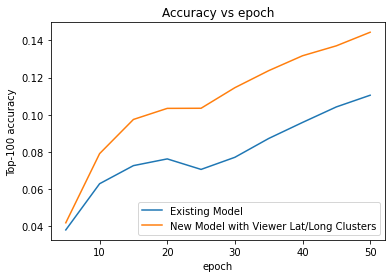

In [35]:
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, old_model_history.history["factorized_top_k/top_100_categorical_accuracy"], label="Existing Model")
plt.plot(epochs, new_model_history.history["factorized_top_k/top_100_categorical_accuracy"], label="New Model with Viewer Lat/Long Clusters")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [36]:
accuracy = old_model_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.4f}.")

Top-100 accuracy: 0.1105.


In [37]:
accuracy = new_model_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.4f}.")

Top-100 accuracy: 0.1444.
